In [2]:
# -*- coding: utf-8 -*- 
# This code is written in Python 3.7. To install the required packages, run the following commands:
# pip install pandas numpy matplotlib seaborn scikit-learn sympy
# This code is applicable to the CICIDS2017 dataset. 
# implemented Max Voting tech. 


import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load the dataset
df = pd.read_csv('/home/ibibers@ads.iu.edu/Intrusion_Detection_System_IDS/Advanced_Ensemble_techniques/Stacking/CICIDS2017_combined_dataset.csv')

# Drop duplicates: same observation but multiple occurences
main_df_1 = df.drop_duplicates(keep='first')

# Drop columns that have just one unique value, the model wont learn form columns like this.
one_value = main_df_1.columns[main_df_1.nunique() == 1]
main_df_2 = main_df_1.drop(columns = one_value, axis=1)

# Fill nan values
main_df_2['Flow Bytes/s'] = main_df_2['Flow Bytes/s'].fillna(main_df_2['Flow Bytes/s'].mean())

# Remove leading space character in all feature names
main_df_2.rename(columns=lambda x: x.lstrip(), inplace=True)

sample_df_1 = main_df_2.copy()
# Extract subsample of data
print (" Extract subsample of data: ")
print (sample_df_1['Label'].value_counts())


/tmp/ipykernel_211939/2623375716.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


 Extract subsample of data: 
Label
BENIGN                        2096484
DoS Hulk                       172849
DDoS                           128016
PortScan                        90819
DoS GoldenEye                   10286
FTP-Patator                      5933
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1953
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


In [3]:
# Label encoding to convert categorical data to numerical data
le = LabelEncoder()
sample_df_1['Label'] = le.fit_transform(sample_df_1['Label'])

# Extract subsample of data
print (" Extract subsample of data: ")
print (sample_df_1['Label'].value_counts())

 Extract subsample of data: 
Label
0     2096484
4      172849
2      128016
10      90819
3       10286
7        5933
6        5385
5        5228
11       3219
1        1953
12       1470
14        652
9          36
13         21
8          11
Name: count, dtype: int64


In [4]:
# Take a random sample of the dataset
# sample_df_1 = sample_df_1.sample(frac= 0.1, random_state=42)

print("Sampled Dataset Overview:")

# feature_names = list(sample_df_1.columns[:-2]) 
# target_names = ['Benign', 'Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttp', 'DoS slowloris', 'FTP-Patator', 'Heartbleed', 'Infiltration', 'PortScan', 'SSH-Patator', 'Web Attack - Brute Force', 'Web Attack - Sql Injection', 'Web Attack - XSS']

dropped_df = ['Label', 'Flow Packets/s', 'Flow Bytes/s']
X = sample_df_1.drop( dropped_df, axis=1) 
y = sample_df_1['Label']  


Sampled Dataset Overview:


In [6]:
print("Class distribution in y:", pd.Series(y).value_counts())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize the three models
LR_model = LogisticRegression(random_state=1)
dt_model = DecisionTreeClassifier(random_state=1)
Rd_model = RandomForestClassifier(random_state=1)


In [7]:
# initialize the voting classifier and specify the voting type to be hard voting
# the estimator parameter is a list containing the three models we have initialized
Vot_model = VotingClassifier(estimators=[('lr', LR_model), ('dt', dt_model)], voting='hard')
Vot_model.fit(X_train,y_train)
Vot_model.score(X_test,y_test)

/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9263151356730263

In [8]:
# Make predictions on the test set
y_pred_encoded = Vot_model.predict(X_test)

In [9]:
# Use inverse_transform to get original labels
y_pred = le.inverse_transform(y_pred_encoded)
y_test_labels = le.inverse_transform(y_test)

# Create a mapping between numerical labels and their corresponding real labels
label_mapping = {label: le.inverse_transform([label])[0] for label in set(y_test)}
print (label_mapping)


{0: 'BENIGN', 1: 'Bot', 2: 'DDoS', 3: 'DoS GoldenEye', 4: 'DoS Hulk', 5: 'DoS Slowhttptest', 6: 'DoS slowloris', 7: 'FTP-Patator', 8: 'Heartbleed', 9: 'Infiltration', 10: 'PortScan', 11: 'SSH-Patator', 12: 'Web Attack � Brute Force', 13: 'Web Attack � Sql Injection', 14: 'Web Attack � XSS'}


In [10]:
# Evaluate the model
accuracy = accuracy_score(y_test_labels, y_pred)
print("Accuracy:" ,accuracy)


Accuracy: 0.9263151356730263


In [11]:
#  Classificaiton Report 
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred))


Classification Report:


/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

                    BENIGN       0.92      1.00      0.96    628945
                       Bot       1.00      0.02      0.04       586
                      DDoS       0.89      0.70      0.78     38405
             DoS GoldenEye       1.00      0.27      0.42      3086
                  DoS Hulk       1.00      0.82      0.90     51855
          DoS Slowhttptest       0.95      0.74      0.83      1568
             DoS slowloris       1.00      0.31      0.47      1615
               FTP-Patator       0.00      0.00      0.00      1780
                Heartbleed       0.00      0.00      0.00         3
              Infiltration       0.00      0.00      0.00        11
                  PortScan       0.00      0.00      0.00     27246
               SSH-Patator       0.00      0.00      0.00       966
  Web Attack � Brute Force       0.00      0.00      0.00       441
Web Attack � Sql Injection       0.00      0.00

/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


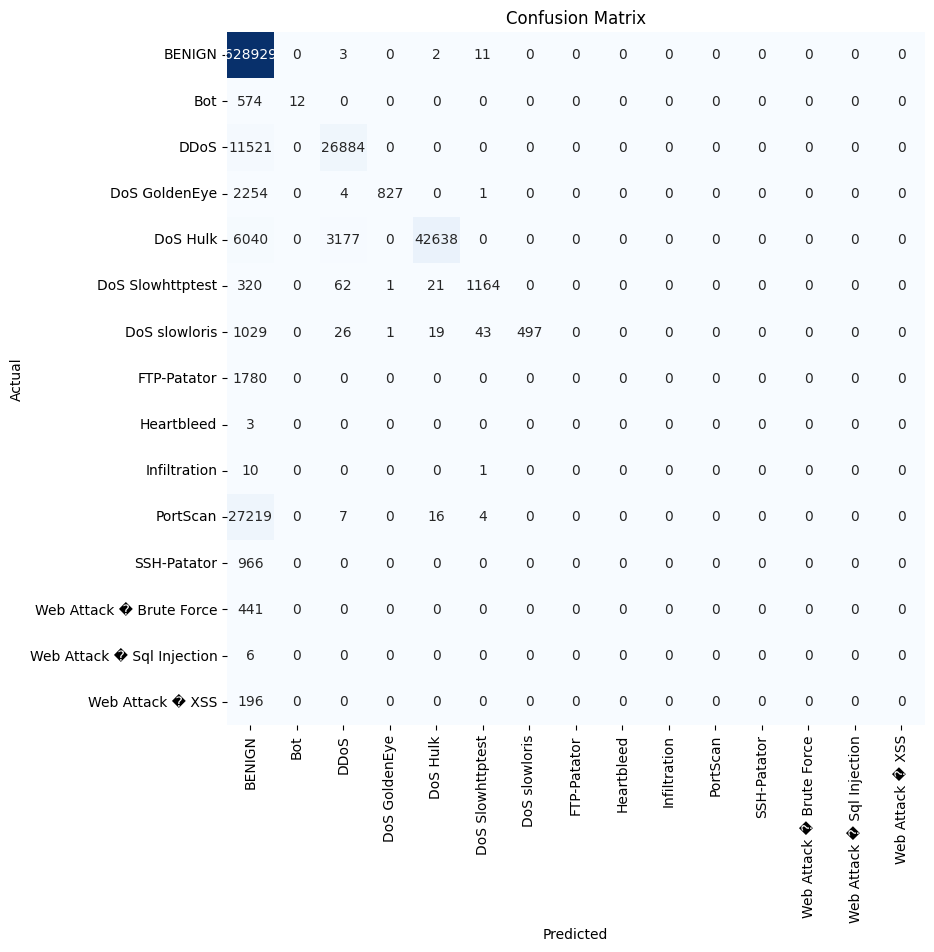

In [12]:
# Confusion matrix with string labels
conf_mat = confusion_matrix(y_test_labels, y_pred, labels=le.classes_)

# Plotting the Confusion Matrix
plt.figure(figsize=(9, 9))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=le.classes_.tolist(), yticklabels=le.classes_.tolist())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



/tmp/ipykernel_211939/2111214029.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(sorted_importance.values()), y=list(sorted_importance.keys()), palette='cubehelix')


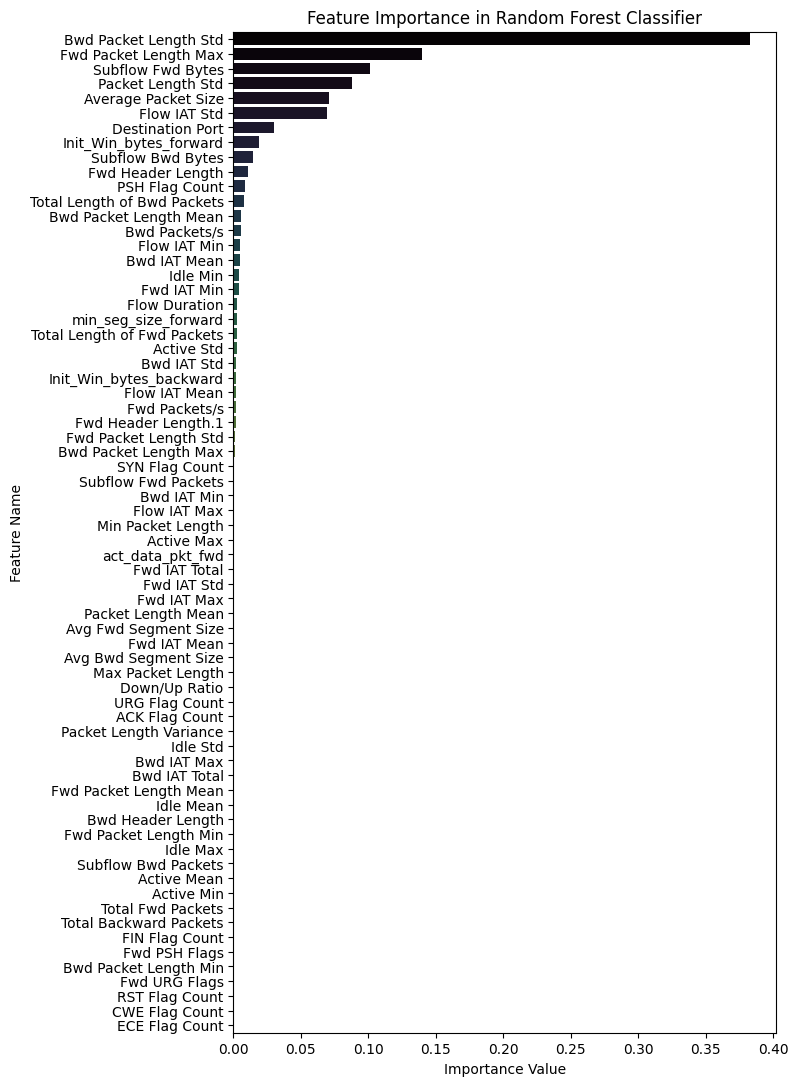

In [13]:
# importances of features in the decision tree model 
importance = Vot_model.estimators_[1].feature_importances_
importance_dict = dict(zip(X.columns.values, importance))
sorted_importance = dict(sorted(importance_dict.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(7, 13))
sns.barplot(x=list(sorted_importance.values()), y=list(sorted_importance.keys()), palette='cubehelix')
plt.xlabel('Importance Value')
plt.ylabel('Feature Name')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()


